In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [3]:
df = pd.read_csv('ETH-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868
1,1/2/2019,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369
2,1/3/2019,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880
3,1/4/2019,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535
4,1/5/2019,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928


**<h3>ARIMA 7-2-1</h3>**

In [4]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

                  Close
Date                   
2019-01-01   140.819412
2019-01-02   155.047684
2019-01-03   149.135010
2019-01-04   154.581940
2019-01-05   155.638596
...                 ...
2023-03-27  1715.460815
2023-03-28  1772.785645
2023-03-29  1793.001831
2023-03-30  1792.737183
2023-03-31  1822.022095

[1551 rows x 1 columns]


In [5]:
print(len(df))
print(len(train_data))
print(train_size)

1551
1085
1085


In [6]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.8 MB/s eta 0:00:00


In [7]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12740.118, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12745.833, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12734.071, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12734.325, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12745.612, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12736.071, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12736.076, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12738.085, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12734.293, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.682 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [8]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [9]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[3936.4627134  3940.05033432 3943.52911272 3947.02011189 3950.50973893
 3953.99952002 3957.48928382 3960.97904956 3964.46881509 3967.95858063
 3971.44834618 3974.93811172 3978.42787727 3981.91764281 3985.40740836
 3988.8971739  3992.38693945 3995.87670499 3999.36647054 4002.85623608
 4006.34600163 4009.83576717 4013.32553272 4016.81529826 402

In [10]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('MAE:', mae)

MAE: 2275.7682687818724


In [11]:
mse = mean_squared_error(y_test,y_pred)
print('MSE:', mse)

MSE: 6384605.932799221


In [12]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:', rmse)

RMSE: 2526.7777766949


In [13]:
r2 = r2_score(y_test, y_pred)
print('r2:', r2)

r2: -8.321802931516315


In [14]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape
mape = mape(y_test, y_pred)
print('MAPE:', mape)

MAPE: 1.4008010123681098


Validation RMSE: 2749.1414402514743
Testing RMSE: 2526.7777766949
Validation MAPE: 1.9272527054096444
Testing MAPE: 1.4008010123681098


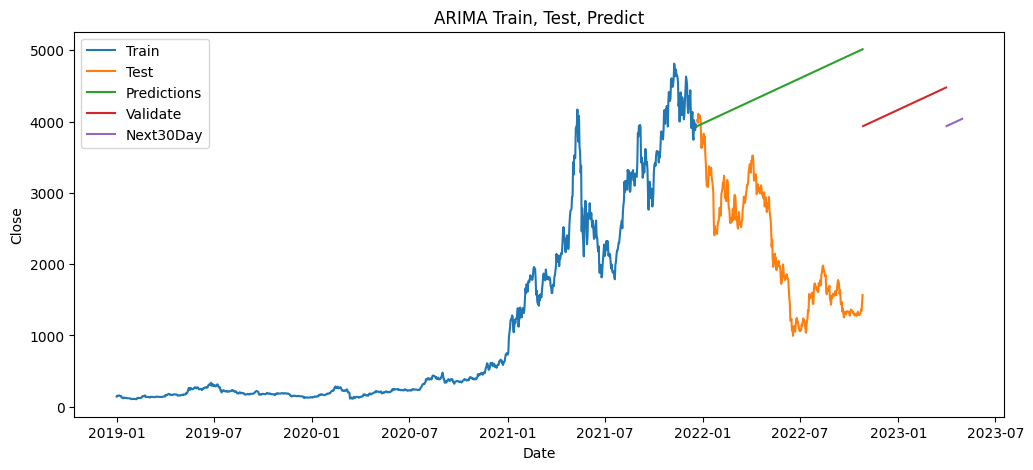

In [15]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()